# Extração da característica de relação sinal-ruído de dados de EEG
A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [97]:
import numpy as numpy
import matplotlib.pyplot as plt

In [98]:
# Criando dados fictícios
# pensando em um vídeo de 10 minutos, com uma taxa de amostragem de 250 Hz
#   teremos 10 * 60 * 250 = 150.000 amostras (sinal com foco)
#   teremos 1 * 60 * 250 = 15.000 amostras (basal)

import numpy as np


shape = (150000, 8)
data_focus = np.random.normal(loc=0, scale=10, size=shape).astype(np.float32)

shape = (15000, 8)
data_base = np.random.normal(loc=0, scale=10, size=shape).astype(np.float32)

In [99]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# armazena uma lista com as médias de potência para cada canal
noise_power = []
for channel_data in data_base.T:
    fft_result = np.fft.fft(channel_data)
    # densidade espectral de potência (PSD)
    psd = np.abs(fft_result) ** 2
    # média da potência no intervalo de tempo sem estímulo
    base_power = np.mean(psd)
    noise_power.append(base_power)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = np.mean(noise_power)
print(estimated_background_noise)

1489153.8


In [100]:
# agora vamos adaptar ambas características 
# aplicando para o nosso sinal de interesse

# forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
target_amplitudes_adjusted = data_focus - estimated_background_noise

# subtraindo o ruído de fundo das amplitudes
narrow_band_SNR = 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)
print(narrow_band_SNR)
print(narrow_band_SNR.shape)

total_power = np.sum(target_amplitudes_adjusted)
wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
print(wide_band_SNR)
print(wide_band_SNR.shape)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(150000, 8)
[[-60.79182  -60.79182  -60.791763 ... -60.791775 -60.79185  -60.7918  ]
 [-60.791836 -60.791832 -60.791832 ... -60.79184  -60.791832 -60.79185 ]
 [-60.791847 -60.79177  -60.79185  ... -60.791817 -60.791813 -60.791817]
 ...
 [-60.791756 -60.791798 -60.791798 ... -60.79182  -60.791756 -60.791832]
 [-60.791782 -60.791794 -60.7918   ... -60.791763 -60.79176  -60.791836]
 [-60.791786 -60.791817 -60.791817 ... -60.79172  -60.7918   -60.791794]]
(150000, 8)


/tmp/ipykernel_8906/2021880081.py:8: RuntimeWarning: invalid value encountered in log10
  narrow_band_SNR = 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)


Divisão dos dados:7pegar os buffers, separar o que e o que nao é foco, aplicar  calculo acima para cada um dos vetores e depois jogar no SVM, dica, usar o rfe

## Tarefa para aplicação das características SNR:
Agora que temos os dois vetores de características SNR, podemos utilizar buffers com e sem a evocação dos rítmos que caracterizam o foco.

### Divisão dos dados
Utilizando a iteração (por exemplo, de 5 segundos caracterizada pela janela) realizada no sinal a cada ~1 segundo, realize a rotulação dos dados de interesse (Beta e Gamma). Ou seja, cada amostra sera um sinal de 5 segundos (1250 pontos de 8 canais). A janela que não for qualificada como Beta ou Gama por exemplo, poderá ser rotulada com "desfoque". Se acharem interessante, adicionar rótulos do ritmo Theta também.

No caso do sinal que representa o basal (se tiverem) poderá pegar um único sinal de aproximadamente 30 segundos para ser utilizado na equação de ruído, que irá ter como resultado um único valor. Lembrando que o valor de ruído deve atuar no sinal no domínio da frequência.

### Classificação
Em nossos dados simulados, temos 150.000 pontos com 8 canais. A utilização desses dados funcionará da seguinte forma para a criação do vetor de características:

150.000 (pontos totais) / 250 (taxa de amostragem) = 600 segundos
600 / 5 (tamanho da janela sem sobreposição) = 120 amostras
1	SNRw1	SNRw2	...	SNRw8	SNRn1	SNRn2	...	SNRn8
2	[w1, w2, ..., w1250]							
3								
...								
120								
Agora transforme cada um dos vetores de pontos no domínio da frequência (1250 pontos) em um único valor real. Neste caso pode ser utilizado tanto a média como a mediana (ou ambos). Se utilizarmos as duas, teremos no final 32 colunas de características:
8 canais
SNR narrow e SNR wide (2)
Média e mediana (2)
1	1	...	32
2	w'	...	
3	...		
...			
120			
Após obter o vetor de característica, realizar a divisão dos dados em treinamento e teste (normalmente uma proporção de 70 e 30% respectivamente) e aplicar para o classificador SVM.

PLUS: Ao final da tarefa, verificar a melhora dos resultados utilizando um seletor de características. Neste caso, podemos utilizar o RFE (Recursive Feature Elimination) em uma fase anterior a classificação para reduzir as 32 características se for necessário.

## Iniciando a tarefa para a voluntária Daniela Sehaber

O primeiro passo escolhido foi o de seleção de trechos basais, trechos basais são momentos em que o cérebro da pessoa está agindo de forma natural, isto é
são momentos de repouso ou baixa atividade, importantes para ser possível comparar os dados de um pico de atividade com o cérebro da pessoa numa postura
natural/relaxada.

### Imports necessários
Iniciamos o código realizando os imports necessários para que possamos prosseguir na análise e separação de dados.

In [101]:
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Explicação sobre os dados escolhidos
Analisando os dados do EEG da paciente, é notável que a mesma é uma pessoa que possui ondas Beta em maiores taxas que as outras ondas em grande parte do tempo, tendo isto em vista, foi selecionado uma parte em que há uma disputa maior entre o beta e o theta para ser utilizada como basal.
### Separando os dados que serão utilizados como basais

Após realizados os imports, será necessário prosseguir ao aplicativo OpenBCI para selecionar os trechos de tempo onde é possível identificar um estado Basal na paciente
para isso foi selecionado o tempo de: 1:30 à 2:30 de Glucagon Ativo e o arquivo: 'OpenBCI-RAW-2023-10-26_13-06-25.txt'

### Criando funções auxiliares para seleção dos tempos

Agora serão criadas as funções auxiliares para a seleção dos tempos.

In [102]:
def minutosParaSegundos(tempo):
    minutos, segundos = map(int, tempo.split(":"))
    return minutos * 60 + segundos

def converteIntervaloTempoParaIndice(intervaloTempo):
    inicio, fim = map(str, intervaloTempo.split(" - "))
    novoInicio = minutosParaSegundos(inicio)
    novoFim = minutosParaSegundos(fim)
    
    indice = []
    indice.append(novoInicio * 250)
    indice.append(novoFim * 250)

    return indice

### Atribuição do objeto MNE
Após selecionado o tempo basal, é necessário criar um objeto mne para podermos trabalhar de maneira simples através da linguagem python, para isso, é necessário criar um objeto info como será descrito abaixo:

Esse código configura a estrutura básica para a criação de um objeto `Info` no MNE-Python, que é uma biblioteca popular para análise de dados de neurociência, como EEG (eletroencefalograma). Vou explicar cada parte:

1. **`n_channels = 8`**:
   - Define o número de canais no EEG, que é 8 nesse caso.

2. **`ch_types = ['eeg'] * n_channels`**:
   - Cria uma lista de tipos de canais, onde todos os canais são do tipo 'eeg'. A lista tem 8 elementos (um para cada canal), todos com o valor `'eeg'`.

3. **`sfreq = 250`**:
   - Define a frequência de amostragem (sampling frequency) do EEG, que é 250 Hz. Isso significa que o sinal é amostrado 250 vezes por segundo.

4. **`ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]`**:
   - Especifica os nomes dos canais EEG. Esses nomes são baseados no sistema internacional 10-20 de posicionamento dos eletrodos no escalpo. Cada nome corresponde a um local específico na cabeça.

5. **`info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)`**:
   - Cria um objeto `Info` que contém metadados sobre o conjunto de dados EEG, como os nomes dos canais, a frequência de amostragem e os tipos de canais.

6. **`info.set_montage("standard_1020")`**:
   - Define o arranjo espacial dos eletrodos no escalpo usando o padrão "standard_1020". O sistema 10-20 é um padrão internacional para a colocação de eletrodos no EEG, garantindo que os dados sejam registrados de forma consistente e comparável.

Resumindo, esse código configura a estrutura básica de metadados para um EEG com 8 canais, cada um com um nome específico, todos amostrados a 250 Hz, e posicionados de acordo com o sistema 10-20. Isso prepara os dados para análises subsequentes no MNE-Python.


In [103]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

### Extraindo os dados do arquivo para poder utilizar no código
Até o momento, não foram trabalhados os dados dentro do código python, o próximo passo é ler os dados dentro do programa como se segue:

In [104]:
ga = 'datasets/Daniella Sehaber/Glucagon Ativo/OpenBCI-RAW-2023-10-26_12-43-47.txt'
gaOb = np.loadtxt(ga, delimiter=',', skiprows=5, usecols=range(1, 9))

### Calculando o basal para o intervalo de tempo 

Agora iremos utilizar o basal anteriormente descrito e calcular os índices do mesmo

In [105]:
# Defina o intervalo de tempo
intervaloTempo = "1:30 - 2:30"

indices = converteIntervaloTempoParaIndice(intervaloTempo)

print(indices)

dadosRecortadosGa = gaOb[indices[0]:indices[1], :]

# Crie o dicionário X com os dados recortados
X = {
    'ga': mne.io.RawArray(dadosRecortadosGa.T, info),
}

print(X)

[22500, 37500]
Creating RawArray with float64 data, n_channels=8, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
{'ga': <RawArray | 8 x 15000 (60.0 s), ~953 kB, data loaded>}


### Visualizando o trecho basal

Abaixo iremos visualizar os dados basais para verificarmos estatisticamente sua natureza.
Para visualizar os dados de forma correta, passaremos um filtro de passa baixa, removeremos artefatos atraves do ICA (independent component analysis), depois plotaremos o gráfico

In [106]:
dadosCorrigidos = mne.filter.filter_data(dadosRecortadosGa.T, sfreq=250, l_freq=0.5, h_freq=None) # Filtro passa baixa

Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1651 samples (6.604 s)



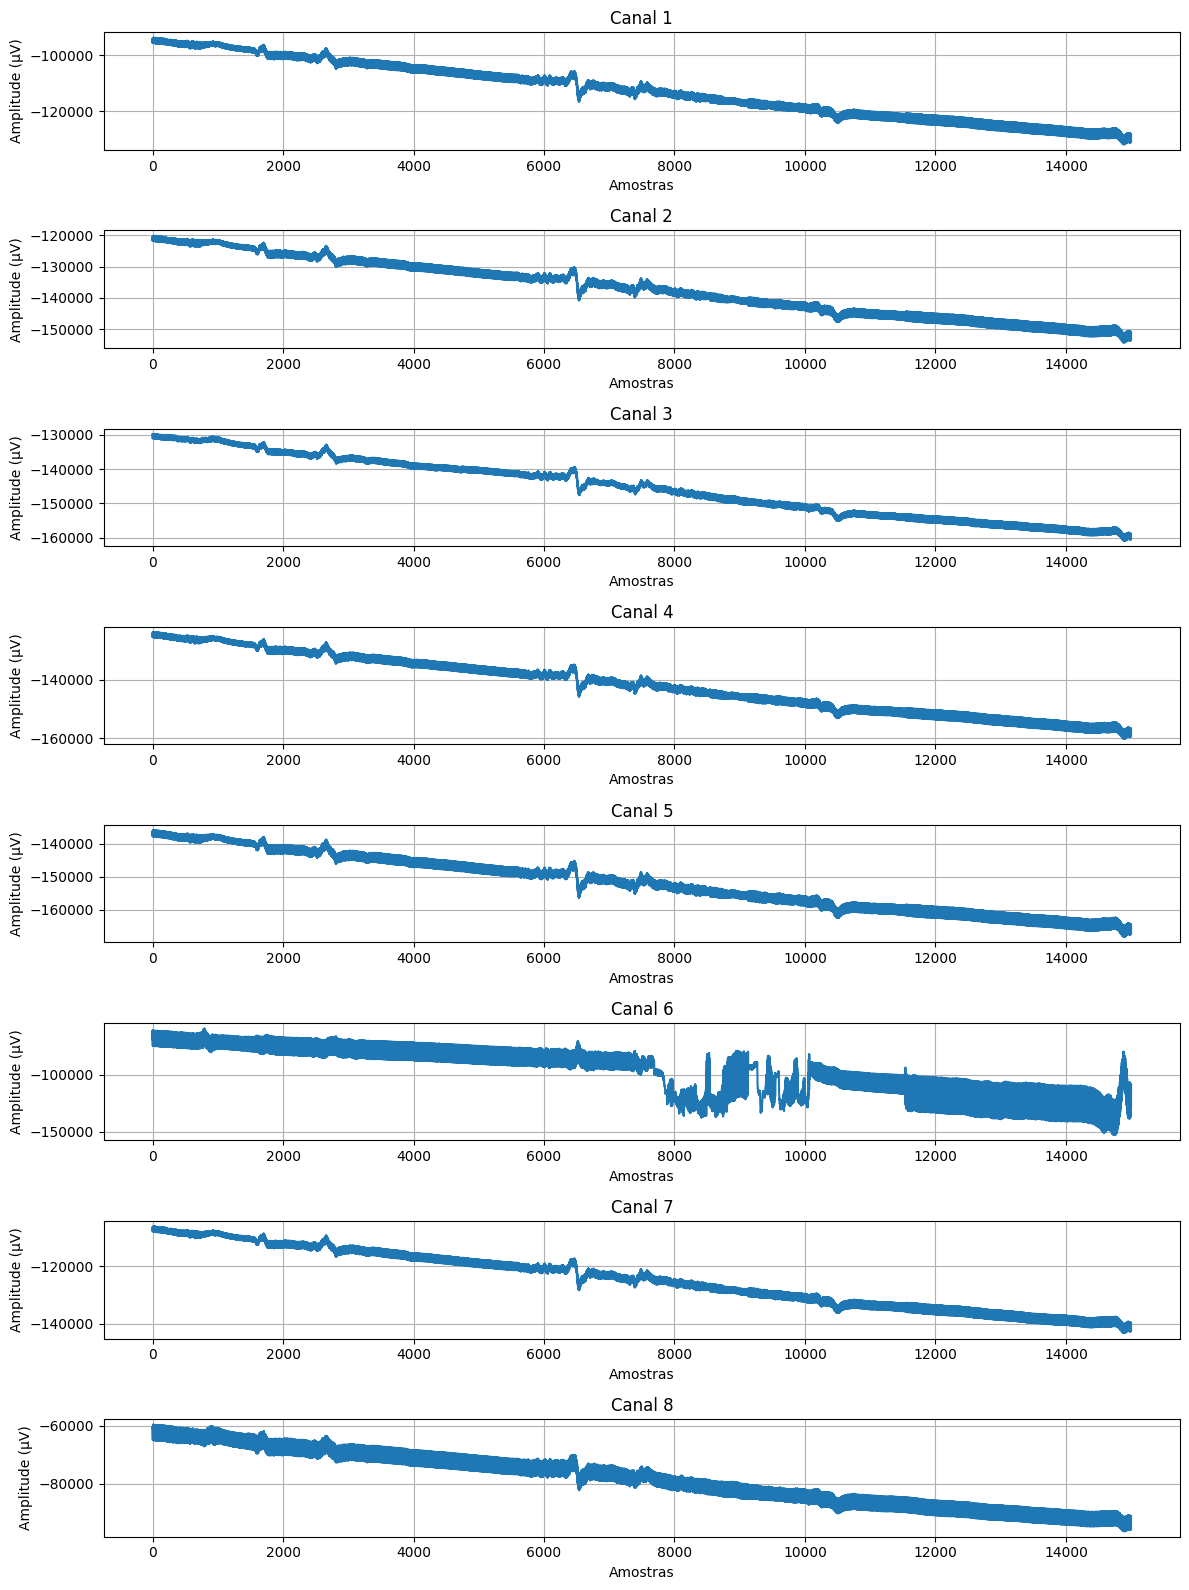

In [107]:
# Número de canais
num_canais = dadosRecortadosGa.shape[1]

# Criar uma figura com subplots
plt.figure(figsize=(12, 2 * num_canais))

# Plotar cada canal em um subplot separado
for i in range(num_canais):
    plt.subplot(num_canais, 1, i + 1)
    plt.plot(dadosRecortadosGa[:, i])
    plt.title(f'Canal {i+1}')
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

### Interpretando os gráficos
É notável que o canal 6 possui muito ruído, para não prejudicar o basal, iremos removê-lo

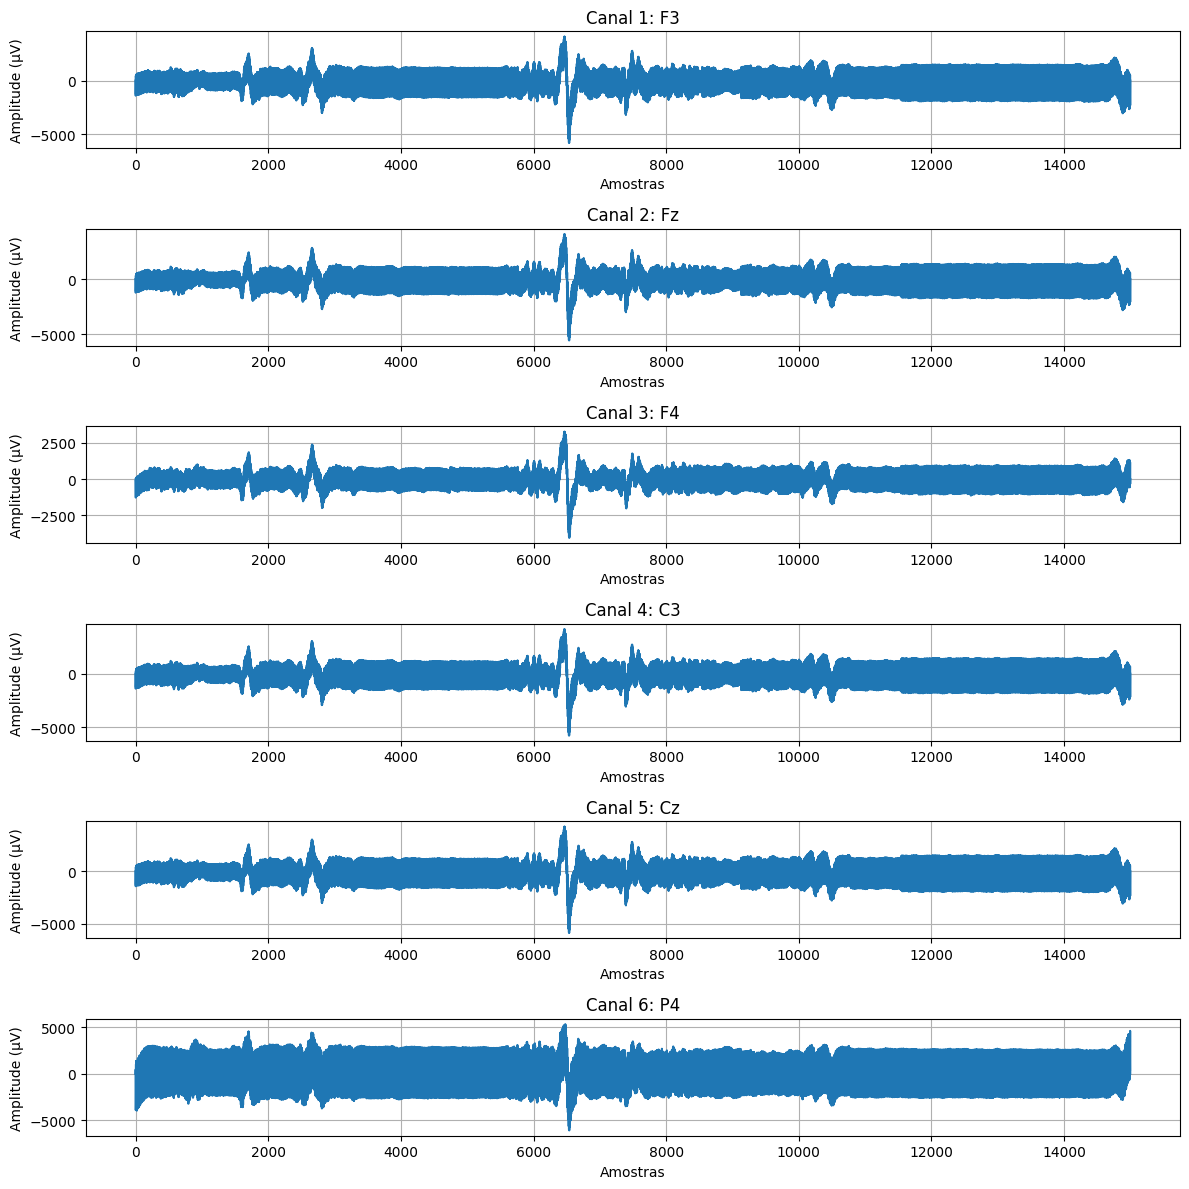

In [108]:
# Obter os nomes dos canais restantes após remoção
nomes_canais_restantes = raw.info['ch_names']

# Obter os dados atualizados
dados_atualizados = raw.get_data()

# Número de canais restantes
num_canais_restantes = dados_atualizados.shape[0]

# Criar uma figura com subplots para os canais restantes
plt.figure(figsize=(12, 2 * num_canais_restantes))

# Plotar cada canal em um subplot separado
for i in range(num_canais_restantes):
    plt.subplot(num_canais_restantes, 1, i + 1)
    plt.plot(dados_atualizados[i, :])
    plt.title(f'Canal {i+1}: {nomes_canais_restantes[i]}')
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

### Realizando a Filtragem dos Dados

Quando tratamos de dados de EEG, estamos lidando com sensores altamente sensíveis que podem captar várias fontes de interferência do ambiente. Para minimizar essas interferências e melhorar a qualidade dos dados, é comum aplicar filtros.

1. **Filtro Notch**:
   - **`X[key].notch_filter(freqs=60)`**: Aplica um filtro notch para remover a interferência de 60 Hz. Essa frequência é comum em ruídos elétricos, como os provenientes de sistemas de iluminação fluorescentes ou de fontes de energia elétrica. O filtro notch é projetado para atenuar ou eliminar essa frequência específica sem afetar significativamente outras frequências.

2. **Filtro Passa-Banda**:
   - **`X[key].filter(l_freq=4, h_freq=100)`**: Aplica um filtro passa-banda que mantém as frequências entre 4 Hz e 100 Hz. Esse tipo de filtro é usado para preservar a gama de frequências de interesse e remover frequências fora desse intervalo, que podem incluir tanto ruídos indesejados quanto componentes de sinal não relevantes.

Portanto, o código que você forneceu está realizando dois tipos de filtragem nos dados EEG para melhorar a qualidade e reduzir o impacto de interferências e ruídos.

In [109]:
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [110]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 2           # Tamanho da janela de análise (4 em 4 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


total_pc = {}
# data_names = ('gt', 'ia', 'tf')
data_names = ('ga',)

electrodes = ["F3", "Fz", "F4"] # , "C3", "Cz", "C4"

# X contém os cinco conjuntos de dados de EEG para análise
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (4s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # Calculando a pontuação de cada banda para mostrar a porcentagem
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 15000 (60.0 s), ~953 kB, data loaded>
{'ga': [31.58, 0.0, 0.0, 68.42]}


In [111]:
rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem de tempo cuja cada banda de\nfrequência teve sua potência proeminete')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem de tempo da atividade')
    plt.show()

Glucagon Ativa


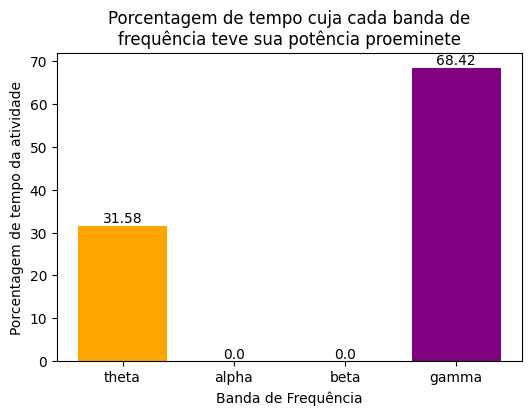

In [112]:
print('Glucagon Ativa')
plot_bar(total_pc['ga'])

In [113]:
import matplotlib.pyplot as plt

def printGraphs(X):
    num_channels = X.shape[1]
    
    # Gráficos no Domínio do Tempo
    plt.figure(figsize=(10, 6))
    for i in range(num_channels):
        plt.plot(X[:, i], label=f'Canal {i+1}')
    plt.title('Sinais de EEG no Domínio do Tempo')
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude (µV)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Gráficos no Domínio da Frequência (Densidade Espectral de Potência)
    plt.figure(figsize=(10, 6))
    for i in range(num_channels):
        plt.psd(X[:, i], Fs=250, label=f'Canal {i+1}')
    plt.title('Densidade Espectral de Potência dos Sinais de EEG')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Potência/Frequência (dB/Hz)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Espectrograma
    plt.figure(figsize=(10, 6))
    for i in range(num_channels):
        plt.specgram(X[:, i], Fs=250, cmap='viridis')
        plt.title(f'Espectrograma do Canal {i+1}')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Frequência (Hz)')
        plt.colorbar(label='Densidade Espectral de Potência (dB/Hz)')
        plt.grid(True)
        plt.show()

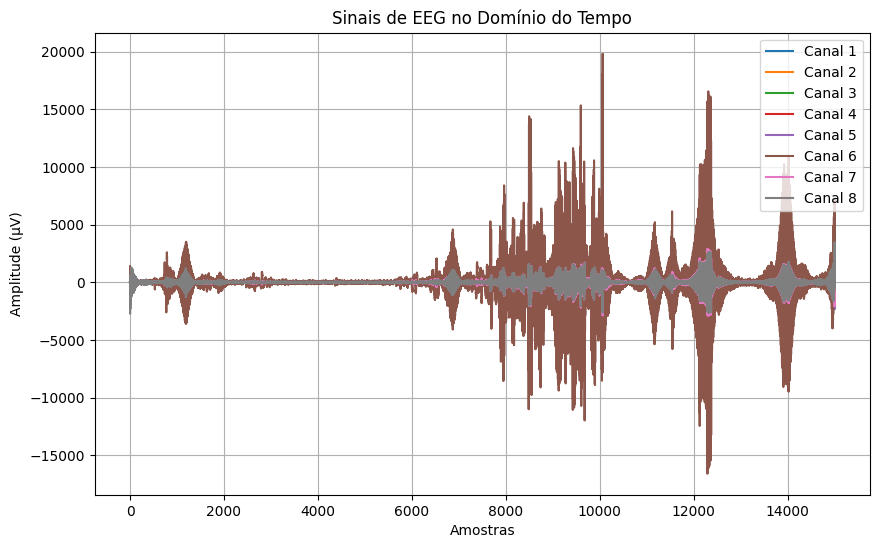

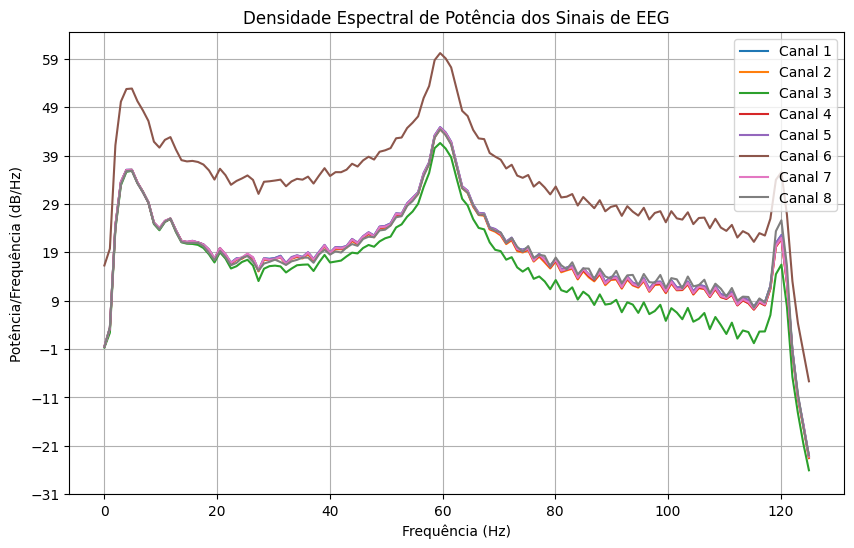

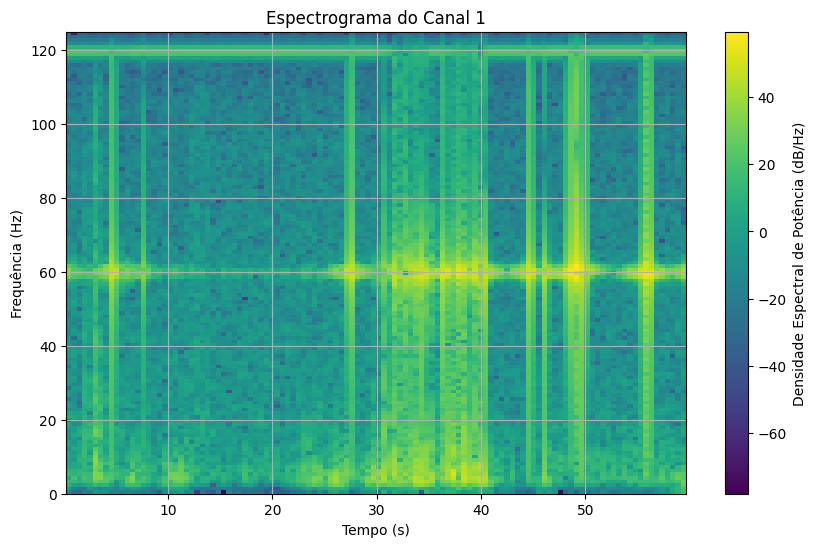

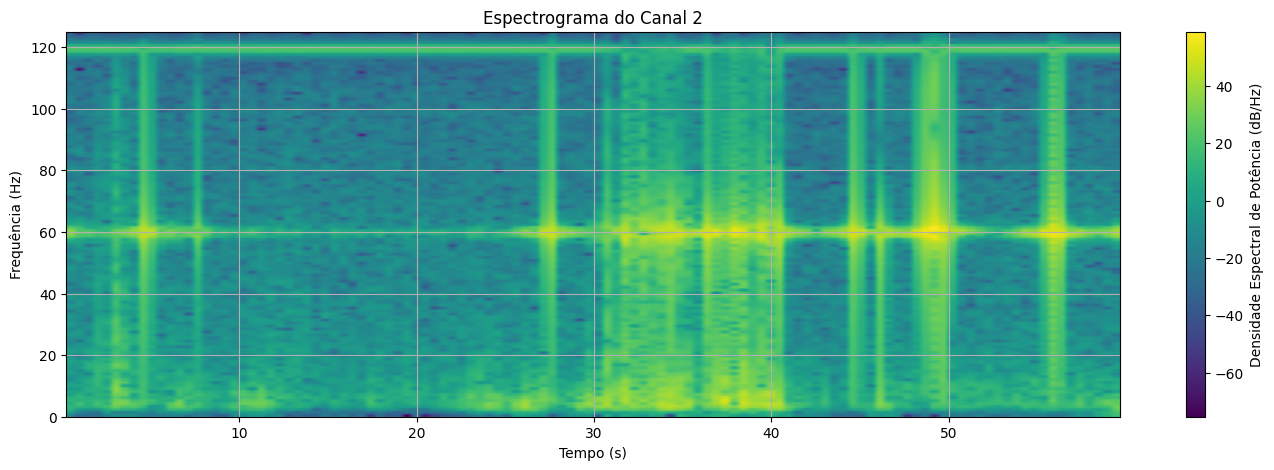

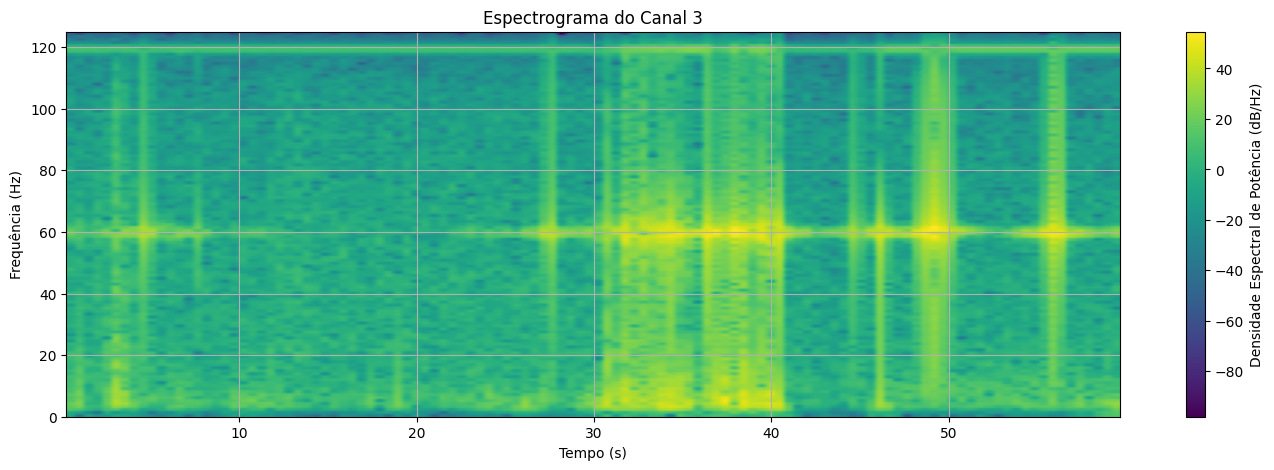

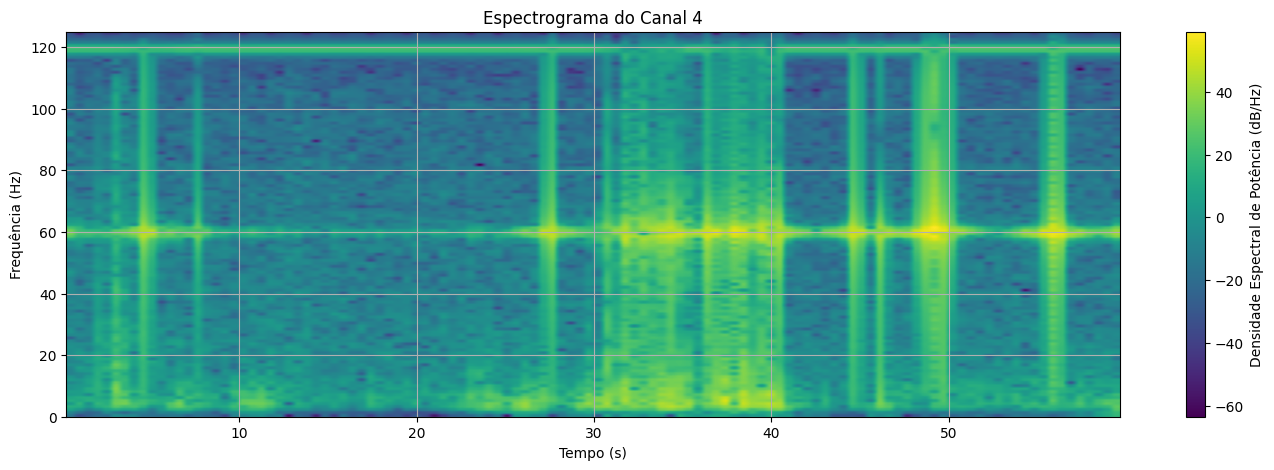

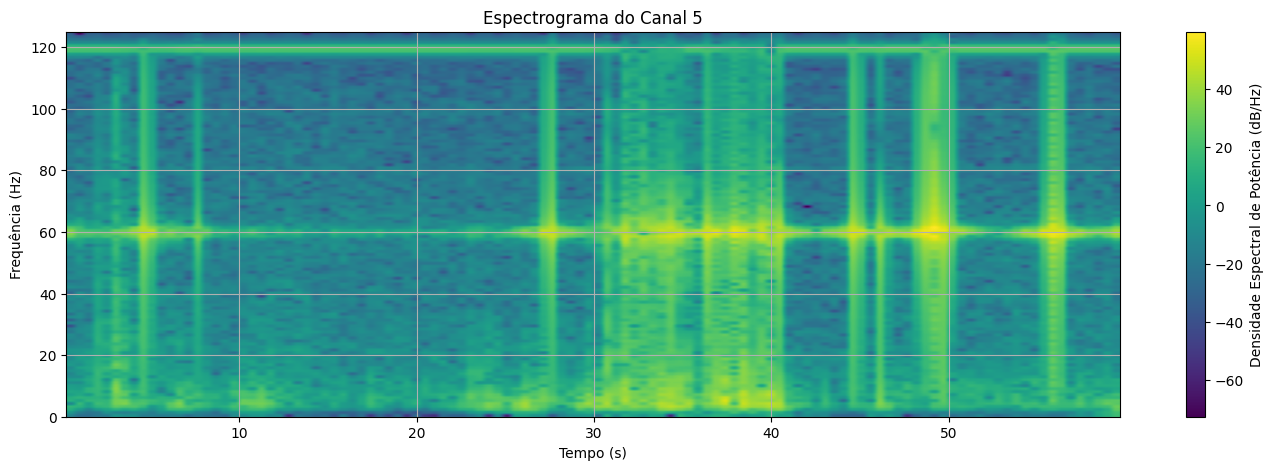

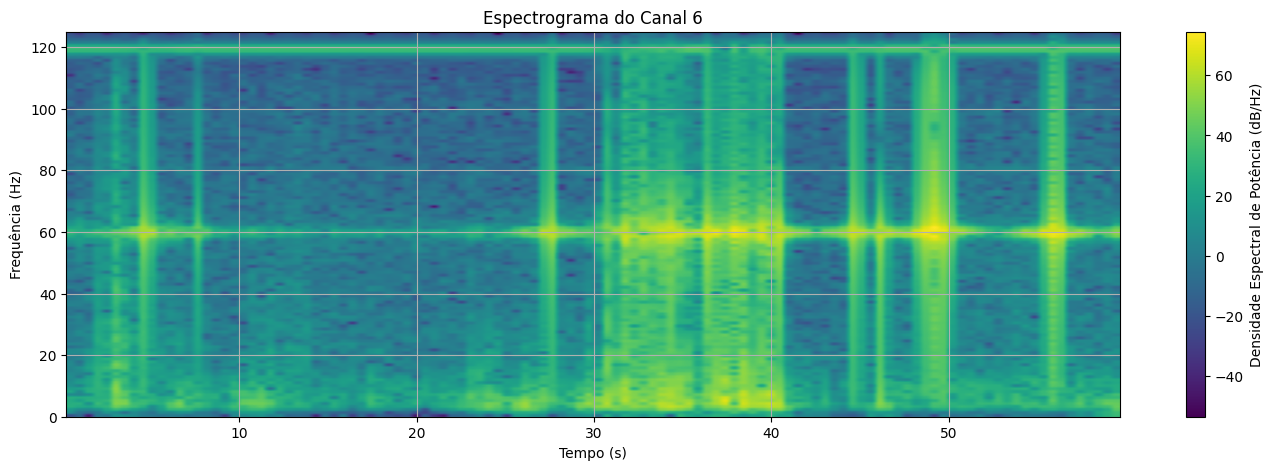

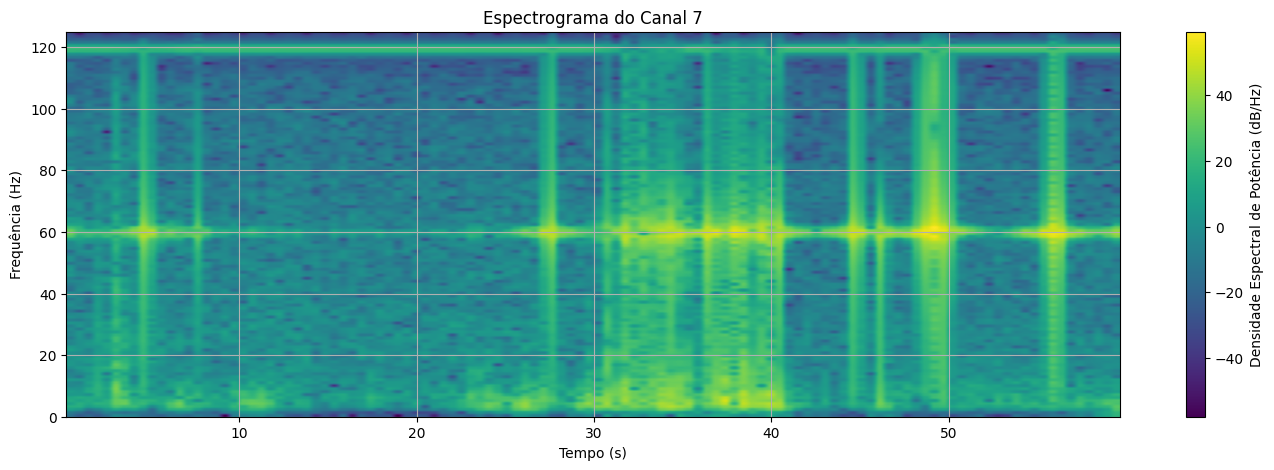

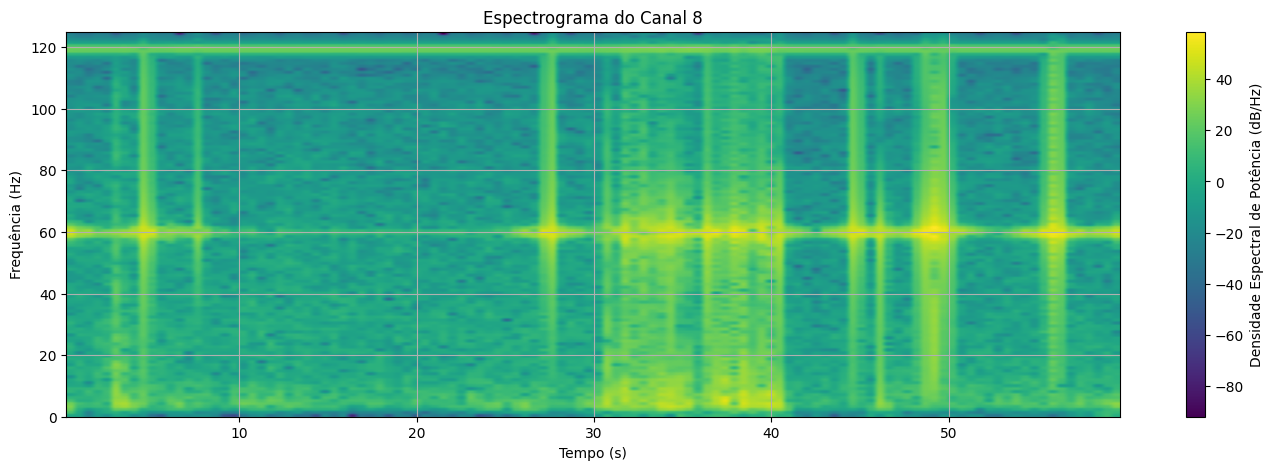

In [114]:
rcParams['figure.figsize'] = [17., 5.]
printGraphs(dadosRecortadosGa)

In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dadosRecortadosGa)

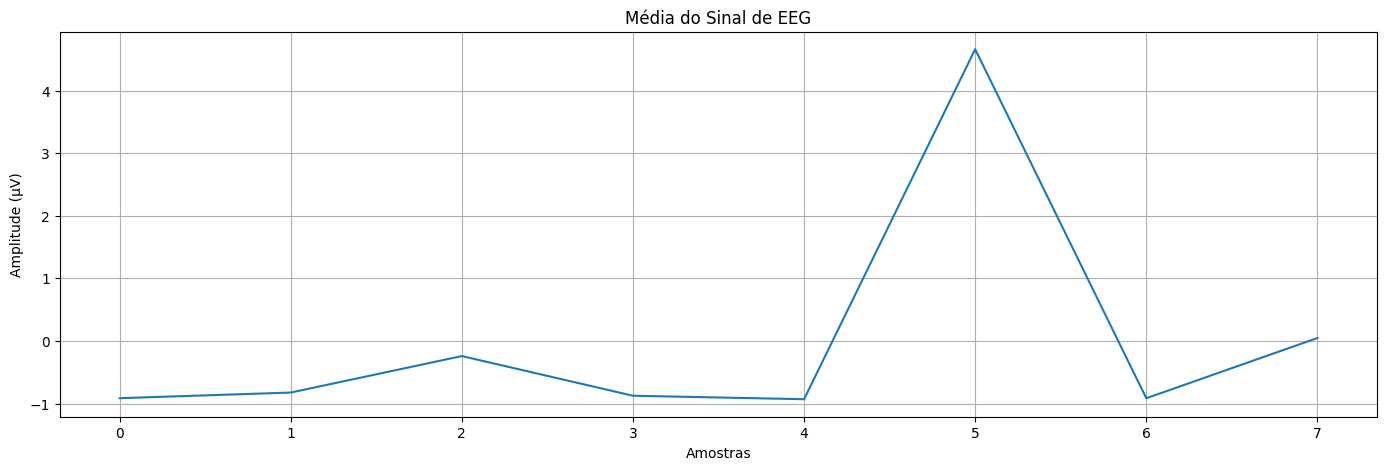

In [116]:
X_mean = dadosRecortadosGa.mean(axis=0)
plt.plot(X_mean)
plt.title('Média do Sinal de EEG')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.show()